# Autoencoder test

Testing concept of classification with autoencoder response. Accompaning blog-post [here](https://amva4newphysics.wordpress.com/).

Autoencoders aim to reproduce their inputs but are forced to compress and decode information. This means that their responce will be different when applied to data they have not been optimised to encode. The difference in response can be used to spot anaomalies in data, without specifiying the signature of the anomaly.

The NB aims to test whether or not this effect can be useful in forming a discriminator similar to that used in the Matric Element Method, by computing the ratio of losses of autoencoders trained on unique data classes

## Import

### Import modules

In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas
import timeit #more accurate than time

import theano

from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.layers import Dense, Activation
from keras.models import Sequential, model_from_json, load_model

from xgboost import XGBClassifier

import seaborn as sns
sns.set_style("white")
import os
import json

from six.moves import cPickle as pickle #Faster than pickle

import sys
sys.path.append('../modules/')
from MPPlot import *
from Processors import *

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.
/home/giles/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Choose backend

In [2]:
import importlib

def set_keras_backend(backend):
    """
    Changes Keras backend
    
    Parameters
    ----------
    backend : str
              Backend wanted (theano or tensorflow)
              
    Returns
    -------
    """
    
    idm = {"theano": "th", "tensorflow": "tf"}
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
        keras.backend.set_image_dim_ordering(idm[backend])

set_keras_backend("theano")

### Import data
Read ROOT files into Pandas dataframe. Pandas is a very fast and flexibly way of handling data in Python. It stores data in RAM, so doesn't handle large files well...

Data is available in both ROOT and CSV format. Pick which you wish to use.

In [3]:
useROOT = False

In [4]:
loc = "../data/"
signalData = None
backgroundData = None

if useROOT: #Load data from ROOT files
    import root_numpy
    signalData = pandas.DataFrame(root_numpy.root2array(loc + "signal.root", treename = 'tree'))
    backgroundData = pandas.DataFrame(root_numpy.root2array(loc + "background.root", treename = 'tree'))
    
else: #Load data from CSV files
    signalData = pandas.read_csv(loc + "signal.csv")
    backgroundData = pandas.read_csv(loc + "background.csv")
    
    # Drop columns without header
    signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)
    backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)
    
print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset

Samples contains 71614 signal events and 103690 background events
175304 events in total


## Configure data
### Process data and add new features
 - t_0 = $\tau_h$
 - t_1 = $\mu$
 - b_0 & b_1 = selected b-jets ordered by $p_T$
 - mPT = missing transverse-momenta
 - h_tt = vector-sum of t_0, t_1, and mPT ($h\rightarrow\tau\tau$)
 - h_bb = vector-sum of b_0 and b_1 ($h\rightarrow bb$)
 - diH = vector-sum of h_tt and h_bb (di-Higgs vector)

In [5]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    addEnergy(data, p) #Calculate energy and absolute momentum
    
moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu

### Create development and validation samples
Development data is used for training and testing. Validation is used for testing the final classifier. Note that the event selection for signal sometimes selects final-states which don't correspond to the Higgs decay products. gen_mctMatch == 1 indicates that the correct final-sates were chosen. For simplicity we'll just consider these signal events.

This defines lists of indices for signal and background events for the development and validation samples. About 20% of each class is reserved for validation

In [6]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)
bkg_devIndeces, bkg_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 0) & (data.gen_mctMatch == 0)].index.tolist()],
                                 test_size=0.2, random_state=1337)

Here we split the full dataset into the dev and val sets, and define aliases for the cuts necessary to select signal and background events in each.

In [7]:
devData = data.loc[sig_devIndeces].copy()
devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data.loc[bkg_valIndeces].copy(), ignore_index = True)

sigDev = (devData.gen_target == 1) & (devData.gen_mctMatch == 1)
bkgDev = (devData.gen_target == 0)
sigVal = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkgVal = (valData.gen_target == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))
print("Dev: {} of which are signal and {} are background".format(len(devData[sigDev]), len(devData[bkgDev])))
print("Val: {} of which are signal and {} are background".format(len(valData[sigVal]), len(valData[bkgVal])))

132076 events for training, 33019 events for validation
Dev: 49124 of which are signal and 82952 are background
Val: 12281 of which are signal and 20738 are background


## Options
Define the features used for discrimination and training options

In [8]:
genFeatures = [var for var in data.columns if str.startswith(var, "gen")] #Generator features; not for training
trainFeatures = [var for var in data.columns if var not in genFeatures] #Reconstructed features; ok for training

We no longer need the old $p_T$, $\eta$, and $\phi$ coordinates so remove them from the training features. 't_1_mass' is also constant ($m_{\mu}$) so let's remove that too.

In [9]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi', 't_1_mass'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi]

### Training options

In [11]:
autoTrainFeatures = trainFeatures #Features used for encoding
autoModel = 'model0' #Version of network to use
varSet = 'fsFeatures' #Name holder for saving

normIn = True #Normalise inputs
normOut = True #Normalise outputs
pcaIn = True #Decorrelate inputs
pcaOut = True #Decorrelate outputs
normPCA = True #Re-normalise after decorrelation
whiten = False #Whiten during decorrelation

compileArgs = {'loss':'mse', 'optimizer':'nadam'} #Arguments for network training
trainParams = {'epochs' : 10000,  'batch_size' : 64, 'verbose' : 0} #Arguments for batch size

autoTargetFeatures = autoTrainFeatures #We want the network to reproduce the inputs

print("\nTraining on", len(autoTrainFeatures), "features:", [var for var in autoTrainFeatures])


Training on 74 features: ['t_0_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'hT', 'sT', 'centrality', 'eVis', 'nJets', 'nBJets', 'nTauJets', 'minJetPT', 'meanJetPT', 'maxJetPT', 'minJetMass', 'meanJetMass', 'maxJetMass', 'minJetEta', 'meanJetEta', 'maxJetEta', 'nPhotons', 'sphericityA', 'spherocityA', 'aplanarityA', 'aplanorityA', 'upsilonA', 'dShapeA', 'sphericityP', 'spherocityP', 'aplanarityP', 'aplanorityP', 'upsilonP', 'dShapeP', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT']


## Train encoder for background
First we'll train the encoder to reproduce the data on a background-only dataset. The loss for background should be as close to zero as possible, and the performance on signal should be worse.

In [12]:
mode = bkgDev

### Preprocess data

Here we define a SK-Learn pipeline which will contain transformation steps for any data fed in. Pipelines are a nice, compact way of handing data transformations.

In [13]:
def getPreProcPipes(normIn=False, normOut=False, pcaIn=False, pcaOut=False, whiten=False, normPCA=False):
    stepsIn = []
    if not normIn and not pca:
        stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
    else:
        if normIn:
            stepsIn.append(('normIn', StandardScaler()))
        if pcaIn:
            stepsIn.append(('pcaIn', PCA(whiten=whiten)))
            if normPCA:
                stepsIn.append(('normPCA', StandardScaler()))
    inputPipe = Pipeline(stepsIn)
    stepsOut = []
    if normOut:
        stepsOut.append(('normOut', StandardScaler()))
        if pcaOut:
            stepsOut.append(('pcaOut', PCA(whiten=whiten)))
            if normPCA:
                stepsOut.append(('normPCA', StandardScaler()))
    else:
        stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
    outputPipe = Pipeline(stepsOut)
    return inputPipe, outputPipe

Next we fit the pipeline to the development data inputs. For compactness we also transform the development data and create Numpy arrays of the inputs and targets. N.B. The type of the inputs will normally be either float32 or float64. float32 is preferred, since speed and memory outweighs precision. Sometimes if the data is naturally in float64, the conversion to float32 can can result in NaNs or infs, so watch out.

Whilst the pipes do have a fit_transform method, I've found that sometimes the response varies when transform is run later, therefore I now fit and transform seperately

In [14]:
inputPipe, outputPipe = getPreProcPipes(normIn, normOut, pcaIn, pcaOut, whiten, normPCA)
inputPipe.fit(devData[mode][autoTrainFeatures].values.astype('float32'))
outputPipe.fit(devData[mode][autoTargetFeatures].values.astype('float32'))

Pipeline(steps=[('normOut', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pcaOut', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('normPCA', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [15]:
X_auto = inputPipe.transform(devData[mode][autoTrainFeatures].values.astype('float32'))
y_auto = outputPipe.transform(devData[mode][autoTargetFeatures].values.astype('float32'))

### Define autoencoder
Here we define the layout of the neural network. The basic class is sequential. The network is them defined by adding dense layers (which contain the neurons and weights) and then the activation function. The activation function can be defined directly in the dense constructor, however adding separately gives a clearer picture of the network, and allows it to be easily replaced with an advanced activation-function.

For contempory ML, the rectified linear unit is generally the default activation function. Since we want the outputs to be between 0 (background) and 1 (signal) we'll use the sigmoid function as the final activation function, since it saturates at these values and is symmetric between them.

The compile step combines the choice of loss function and optimiser into the model.

The structure of the autoencoder aims to compress (encode) the inputs and then decompress (decode) them. The outputs should therefore match the inputs as closely as possible. The compression stage is implemented by severaly reducing the number of neurons in the middle.

In [16]:
def getEncoder(version, nIn, nOut, compileArgs):
    model = Sequential()
    width = None

    if version == "model0":
        width = [100, 10, 100]
        model.add(Dense(width[0], input_dim=nIn, kernel_initializer='he_normal'))
        model.add(Activation('relu'))
        for i in width[1:]:
            model.add(Dense(i, kernel_initializer='he_normal'))
            model.add(Activation('relu'))

    model.add(Dense(nOut, activation='linear', kernel_initializer='glorot_normal'))

    model.compile(**compileArgs)
    return model

### Callbacks
Callbacks are methods that can be called during training. They have a variety of uses such as monitoring training, stopping training early, and saving different versions of the model. Here we define our own callback,  which saves the history of the training.

We want to view the history of the model's performance on the training and testing data during data, however by default the training loss is averaged over the epoch, and the test loss is evaluated at the end of the epoch, so is not comparable. This modified version evaluates the performance on the training data at the end of each epoch.

Later well also use some other callbacks:

EarlyStopping monitors a specified metric and stops the training if the performance fails to improve for a specified number of epochs in a row. Here we use it to monitor the loss on the test data and stop when it doesn't improve after 10 epochs.

ModelCheckpoint is used to save the weights of the network during training. It's quite flexible, but here we use it save the model which performs best according to the loss in test data.

Normally during training, the test loss will reach a minimum and either saturate or start to increase (overtraining). The training loss will normally either saturate or continue to decrease. The optimum point is when the test-loss first reaches its minimum point. The combination of EarlyStopping and ModelCheckpoint acts to save the model at this point and allow some leeway in case it starts to decrease again.

In [17]:
class LossHistory(Callback):
    def __init__(self, trData):
        self.trainingData = trData
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(self.trainingData[0], self.trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

### Train encoder
Now we're ready to train the classifier.

Since this is just a test of concept, we'll skim cross-validation and train once, but still define an intermedeate testing sample, to allow us to change some hyperparameters and still check for over-fitting on the validation data.

In [18]:
def getTrainTestData(inputs, outputs, testSize=0.2, randomState=0):
    return train_test_split(inputs, outputs, test_size=testSize, random_state=randomState)

In [19]:
X_train, X_test, y_train, y_test = getTrainTestData(X_auto, y_auto)

In [20]:
def trainEncoder(X_train, y_train, X_test, y_test, saveLoc = 'train_weights/'):
    start = timeit.default_timer()
    
    model = getEncoder(autoModel, len(X_train[0]), len(y_train[0]), compileArgs)

    os.system('mkdir ' + saveLoc)

    lossHistory = LossHistory((X_train, y_train))
    earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    saveBest = ModelCheckpoint(saveLoc +  "best.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

    model.fit(X_train, y_train,
              validation_data = (X_test, y_test),
              callbacks = [earlyStop, saveBest, lossHistory],
              **trainParams)
    model.load_weights(saveLoc +  "best.h5") #Load best state
    print("Training took {:.3f}s ".format(timeit.default_timer() - start))
    print("Training loss: {:.4f}, Testing loss: {:.4f}".format(model.evaluate(X_train, y_train, verbose=0),
                                                               model.evaluate(X_test, y_test, verbose=0)))
    return model, lossHistory.losses

In [21]:
bkgEncoder, history = trainEncoder(X_train, y_train, X_test, y_test)

Epoch 00079: early stopping
Training took 215.637s 
Training loss: 0.5553, Testing loss: 0.5667


### Plot histories
Now let's plot the history of the training.

We can see that the test loss starts to decrease, reaches a minimum point, then begins to increase. The training loss continues to decrease. The early stopping detects the lack of imporvement in test loss and stops the training. The checkpoint allows us to use the state of the model at the minimum point of training loss.

In [22]:
def plotTrainingHistory(history):
    plt.figure(figsize=(16,8))
    
    plt.plot(history['loss'], color='g', label='Training')
    plt.plot(history['val_loss'], color='b', label='Testing')
    
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16, color='black')
    plt.yticks(fontsize=16, color='black')
    
    plt.xlabel("Epoch", fontsize=24, color='black')
    plt.ylabel("Loss", fontsize=24, color='black')
    
    plt.show()

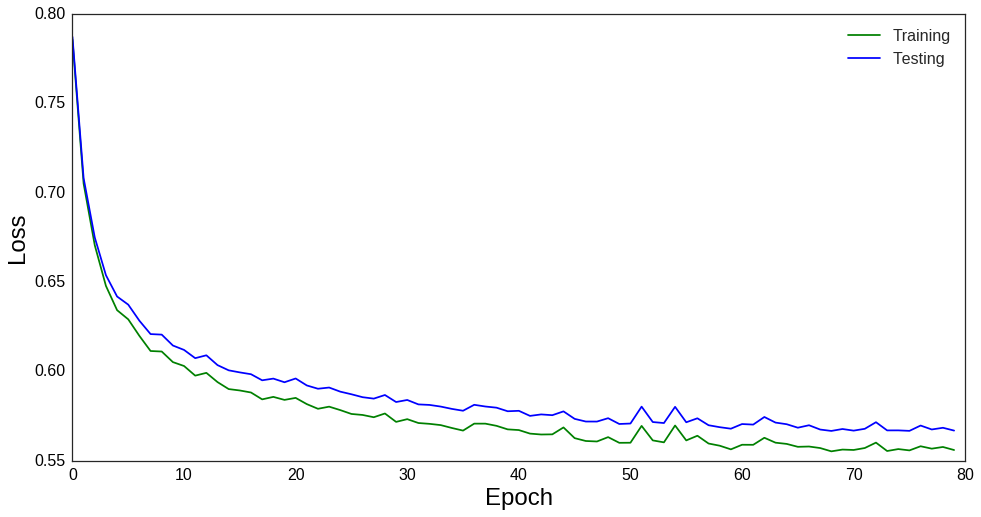

In [23]:
plotTrainingHistory(history)

### Response on validation data
First run the model over the validation data

In [24]:
predDev = bkgEncoder.predict(inputPipe.transform(devData[autoTrainFeatures].values.astype('float32')))
targetDev = outputPipe.transform(devData[autoTargetFeatures].values.astype('float32'))
predVal = bkgEncoder.predict(inputPipe.transform(valData[autoTrainFeatures].values.astype('float32')))
targetVal = outputPipe.transform(valData[autoTargetFeatures].values.astype('float32'))

Then compute the mean sum of the squared difference between the inputs and the outputs (square-error). This should be as close to zero as possible, indicating that the encoding and decoding parts of the autoencoder work well.

The loss on the background autoencoder is saved as a new feature in the validation dataset.

In [25]:
devData['bkg_loss'] = np.sum(np.square(targetDev-predDev)/len(autoTrainFeatures), axis=-1)
valData['bkg_loss'] = np.sum(np.square(targetVal-predVal)/len(autoTrainFeatures), axis=-1)

### Plot the response of the autoencoder for signal and background
We can see that the in general the signal features are reconstructed less well than the background (green distribution is less peaked and extends), indicating that the encoding/decoding is optimised for background, as expected. 

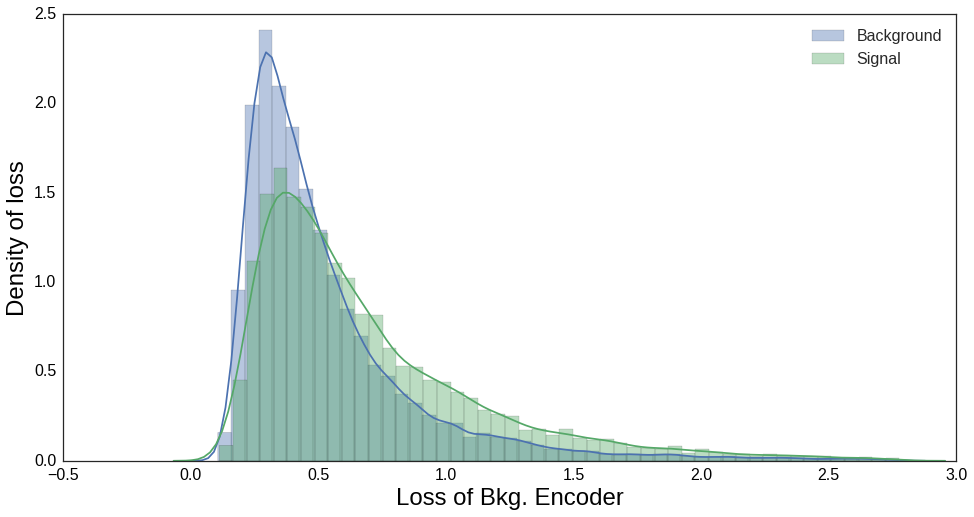

In [26]:
plt.figure(figsize=(16,8))

sns.distplot(valData[bkgVal & (valData.bkg_loss < np.percentile(valData['bkg_loss'], 99))]['bkg_loss'], label='Background')
sns.distplot(valData[sigVal & (valData.bkg_loss < np.percentile(valData['bkg_loss'], 99))]['bkg_loss'], label='Signal')
   
plt.legend(fontsize=16)
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')

plt.xlabel("Loss of Bkg. Encoder", fontsize=24, color='black')
plt.ylabel("Density of loss", fontsize=24, color='black')
    
plt.show()

## Train encoder for signal
Now we'll repeat the process, this time training an encoder optimised for signal, which should reconstruct the background features more poorly.

In [27]:
mode = sigDev

In [28]:
inputPipe, outputPipe = getPreProcPipes(normIn, normOut, pcaIn, pcaOut, whiten, normPCA)
inputPipe.fit(devData[mode][autoTrainFeatures].values.astype('float32'))
outputPipe.fit(devData[mode][autoTargetFeatures].values.astype('float32'))

Pipeline(steps=[('normOut', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pcaOut', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('normPCA', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [29]:
X_auto = inputPipe.transform(devData[mode][autoTrainFeatures].values.astype('float32'))
y_auto = outputPipe.transform(devData[mode][autoTargetFeatures].values.astype('float32'))

In [30]:
X_train, X_test, y_train, y_test = getTrainTestData(X_auto, y_auto)

In [31]:
sigEncoder, history = trainEncoder(X_train, y_train, X_test, y_test)

Epoch 00089: early stopping
Training took 124.367s 
Training loss: 0.5423, Testing loss: 0.5604


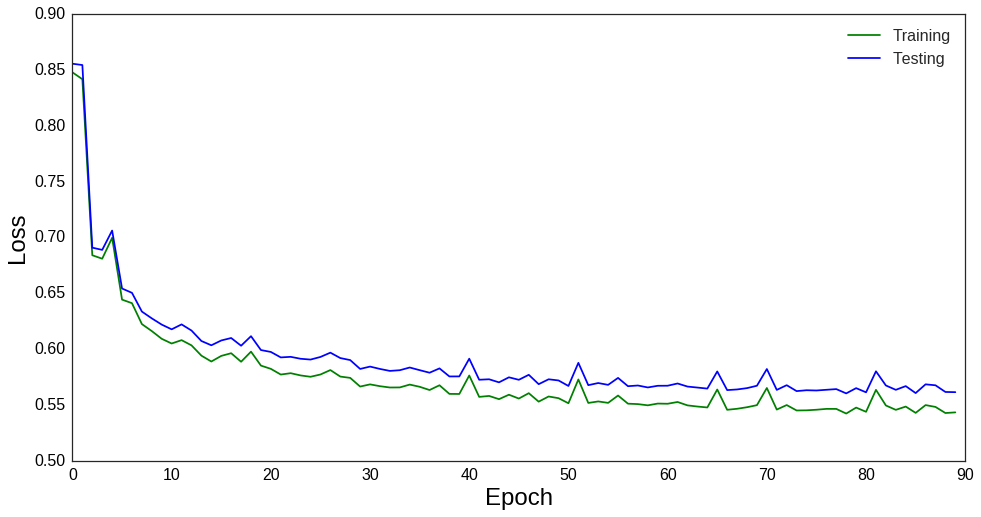

In [32]:
plotTrainingHistory(history)

### Response on validation data

In [33]:
predDev = sigEncoder.predict(inputPipe.transform(devData[autoTrainFeatures].values.astype('float32')))
targetDev = outputPipe.transform(devData[autoTargetFeatures].values.astype('float32'))
predVal = sigEncoder.predict(inputPipe.transform(valData[autoTrainFeatures].values.astype('float32')))
targetVal = outputPipe.transform(valData[autoTargetFeatures].values.astype('float32'))

In [34]:
devData['sig_loss'] = np.sum(np.square(targetDev-predDev)/len(autoTrainFeatures), axis=-1)
valData['sig_loss'] = np.sum(np.square(targetVal-predVal)/len(autoTrainFeatures), axis=-1)

### Plot the response of the autoencoder for signal and background
Again, we can see that the autoencoder reconstructs the inputs for the sample it saw during training, with background displaying a heavy concentration of events in the tail.

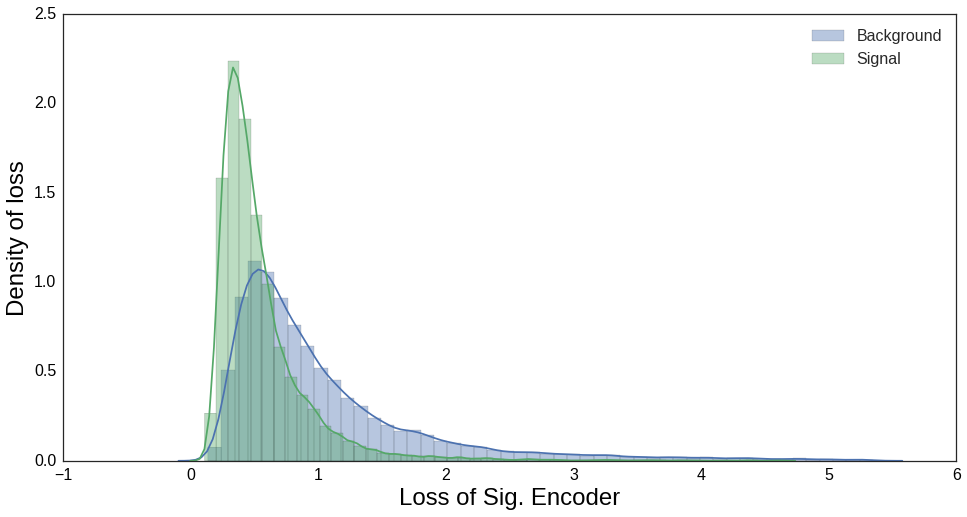

In [35]:
plt.figure(figsize=(16,8))

sns.distplot(valData[bkgVal & (valData.sig_loss < np.percentile(valData['sig_loss'], 99))]['sig_loss'], label='Background')
sns.distplot(valData[sigVal & (valData.sig_loss < np.percentile(valData['sig_loss'], 99))]['sig_loss'], label='Signal')
   
plt.legend(fontsize=16)
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')

plt.xlabel("Loss of Sig. Encoder", fontsize=24, color='black')
plt.ylabel("Density of loss", fontsize=24, color='black')
    
plt.show()

## Discriminator formation
We now have two features providing some discrimination between signal and background. We can combine these into a one-dimensional discriminator by computing the ratio between the two hypotheses: background-only, or signal+background:

## $\Lambda=\frac{L_{\mathrm{Bkg.}}}{L_{\mathrm{Sig.}}+L_{\mathrm{Bkg.}}},$

where $c$ is a parameter we are free to adjust. It affects the relative shapes of the ratio distributions, but shouldn't affect the discrimination offered by the distribution on it's own.

In [36]:
c = 1

In [37]:
devData.ix[:,'loss_sum'] = devData.ix[:,'sig_loss']+(c*devData.ix[:,'bkg_loss'])
devData.ix[:,'loss_ratio'] = devData.ix[:,'bkg_loss']/(devData.ix[:,'loss_sum'])
valData.ix[:,'loss_sum'] = valData.ix[:,'sig_loss']+(c*valData.ix[:,'bkg_loss'])
valData.ix[:,'loss_ratio'] = valData.ix[:,'bkg_loss']/(valData.ix[:,'loss_sum'])

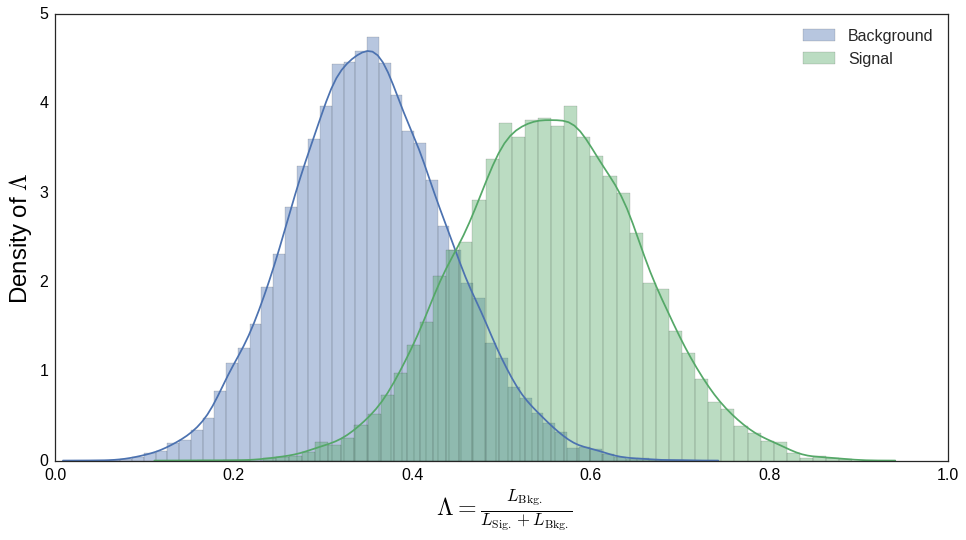

In [48]:
plt.figure(figsize=(16,8))

sns.distplot(valData[bkgVal]['loss_ratio'], label='Background')
sns.distplot(valData[sigVal]['loss_ratio'], label='Signal')

plt.legend(fontsize=16)
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')

plt.xlabel(r" $\Lambda=\frac{L_{\mathrm{Bkg.}}}{L_{\mathrm{Sig.}}+L_{\mathrm{Bkg.}}}$", fontsize=24, color='black')
plt.ylabel(r"Density of $\Lambda$", fontsize=24, color='black')
plt.show()

We can see that signal and background display a surpising amount of separation, considering the overlap the loss plots showed.

Let's look at the receiver operator characteristic (ROC) curve

In [39]:
devScore = roc_auc_score(devData['gen_target'], devData['loss_ratio'])
devCurve = roc_curve(devData['gen_target'], devData['loss_ratio'])[:2]
valScore = roc_auc_score(valData['gen_target'], valData['loss_ratio'])
valCurve = roc_curve(valData['gen_target'], valData['loss_ratio'])[:2]

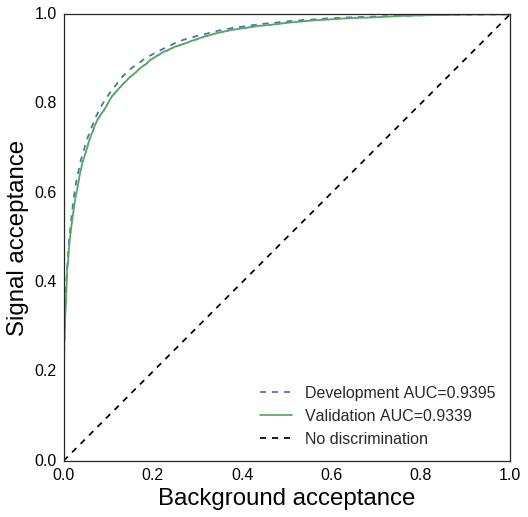

In [41]:
plt.figure(figsize=[8, 8])

plt.plot(*devCurve, linestyle='dashed', label=r'Development AUC={:.4f}'.format(devScore))
plt.plot(*valCurve, label=r'Validation AUC={:.4f}'.format(valScore))
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')

plt.legend(loc='best', fontsize=16)
if devScore > 0.98:
    plt.xscale('log', nonposx='clip')
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.show()

## BDT test

So the descriminator showed that there is some discrimination possible, but not nearly as much as would be provided by a dedicated classifier. Let's see what a BDT can do with the features we've created, though.

In [42]:
feats = [x for x in valData.columns if 'loss' in x]
print('Training on:', feats)

Training on: ['bkg_loss', 'sig_loss', 'loss_sum', 'loss_ratio']


In [43]:
inputPipe, outputPipe = getPreProcPipes(normIn=True)
inputPipe.fit(devData[feats].values.astype('float32'))

X_dev = inputPipe.transform(devData[feats].values.astype('float32'))
y_dev = devData['gen_target'].values.astype('int')
X_val = inputPipe.transform(valData[feats].values.astype('float32'))
y_val = valData['gen_target'].values.astype('int')

In [44]:
xgbClass = XGBClassifier()
xgbClass.fit(X_dev, y_dev)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [45]:
devPred = xgbClass.predict_proba(X_dev)[:,1]
valPred = xgbClass.predict_proba(X_val)[:,1]

devScore = roc_auc_score(devData['gen_target'], devPred)
devCurve = roc_curve(devData['gen_target'], devPred)[:2]
valScore = roc_auc_score(valData['gen_target'], valPred)
valCurve = roc_curve(valData['gen_target'], valPred)[:2]

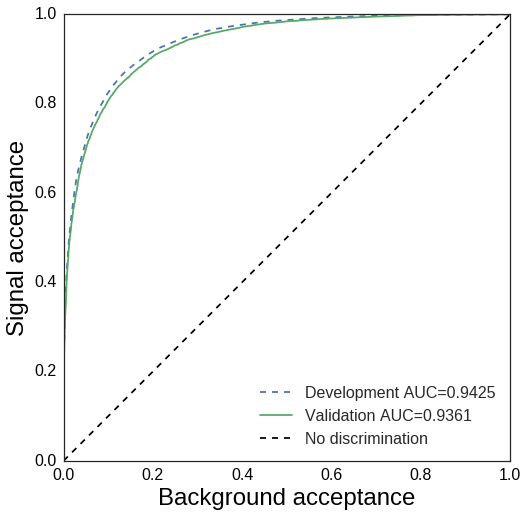

In [46]:
plt.figure(figsize=[8, 8])

plt.plot(*devCurve, linestyle='dashed', label=r'Development AUC={:.4f}'.format(devScore))
plt.plot(*valCurve, label=r'Validation AUC={:.4f}'.format(valScore))
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')

plt.legend(loc='best', fontsize=16)
if devScore > 0.98:
    plt.xscale('log', nonposx='clip')
plt.xticks(fontsize=16, color='black')
plt.yticks(fontsize=16, color='black')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.show()

Some very slight improvements on ROC AUC. Again, nothing to compare to what a dedicated classifier could achieve, however it means that $\Lambda$ captures most of the separation information of the used features andcould be a useful high-level feature to use as an extra input to classifier.